$
\newcommand{\ELBO}{\text{ELBO}}
\newcommand{\EE}{\mathbb{E}}
\newcommand{\bs}[1]{\boldsymbol{#1}}
\newcommand{\ud}{\,\text{d}}
\newcommand{\CN}{\mathcal{N}}
\newcommand{\CB}{\mathcal{B}}
\newcommand{\aux}{\text{aux}}
\newcommand{\do}{do}
\newcommand{\Xmat}{\boldsymbol{X}}
\newcommand{\zv}{\bs{z}}
\newcommand{\xv}{\bs{x}}
\newcommand{\Xv}{\bs{X}}
\newcommand{\Yv}{\bs{Y}}
\newcommand{\BD}{\mathbb{D}}
\newcommand{\KL}{\text{KL}}
$

## T-learner baseline for IHDP
* Tensorflow implementation for MLP and linear models

In [1]:
import os
import sys
# import time
from time import time

import numpy as np
import tensorflow as tf

import pandas as pd
import math

import seaborn as sns

# pip install progressbar2
# from progressbar import ETA, Bar, Percentage, Progress Bar, Dynamic Message

import matplotlib.pyplot as plt
%matplotlib inline

# Allow growth to curb resource drain

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.allow_soft_placement=True
sess = tf.Session(config=config)

In [2]:
class flags:
    
    # dim = 2
    
    x_dim = 25
    y_dim = 1
    t_dim = 2
    # M = 100
    M = 30
    
    # optimization
    learning_rate = 1e-3 # Base learning rate
    lr_decay = 0.999995 # Learning rate decay, applied every step of the optimization
    
    batch_size = 128 # Batch size during training per GPU
    hidden_size = 2
    
    
FLAGS = flags()
args = FLAGS

DTYPE = tf.float32

In [3]:
def int_shape(x):
    return list(map(int, x.get_shape()))

def print_shape(x,varname='variable'):
    if x is None:
        print('%s size: None' % (varname))
        return
    x_shape = x.shape.as_list()
    # print('%s size: [%d,%d,%d]' % (varname,x_shape[1],x_shape[2],x_shape[3]))
    print(varname,end=': ')
    print(x_shape)

def tf_eval(tf_tensor,n_samples,feed_dict=None):
    
    MLOOP = np.int(np.ceil(n_samples/FLAGS.batch_size))
    
    dd = tf_tensor.shape.as_list()[1:]
    dd.insert(0,n_samples)
    
    x = np.zeros(dd)
    
    for mloop in range(MLOOP):
        
        st = mloop*FLAGS.batch_size
        ed = min((mloop+1)*FLAGS.batch_size, n_samples)
        
        if feed_dict is not None:
            feed_dict_i = dict()
            for key in feed_dict.keys():
                feed_dict_i[key] = np.random.randn(*int_shape(key))
                feed_dict_i[key][:ed-st] = feed_dict[key][st:ed]
            y = sess.run(tf_tensor,feed_dict=feed_dict_i)
        else:
            y = sess.run(tf_tensor)
        
        # print([st,ed])
        x[st:ed] = y[:ed-st]
    
    return x

def tf_eval_list(tf_tensor_list,n_samples,feed_dict=None):
    
    if isinstance(tf_tensor_list, list)==False:
        print('Input not a list')
        return None
    
    MLOOP = np.int(np.ceil(n_samples/FLAGS.batch_size))
    
    res = dict()

    for key in tf_tensor_list:
        dd = key.shape.as_list()[1:]
        dd.insert(0,n_samples)
        res[key] = np.zeros(dd)
    
    for mloop in range(MLOOP):
        
        st = mloop*FLAGS.batch_size
        ed = min((mloop+1)*FLAGS.batch_size,n_samples)
        
        if feed_dict is not None:
            feed_dict_i = dict()
            for key in feed_dict.keys():
                feed_dict_i[key] = np.random.randn(*int_shape(key))
                feed_dict_i[key][:ed-st] = feed_dict[key][st:ed]
            # print(feed_dict_i)
            y = sess.run(tf_tensor_list,feed_dict=feed_dict_i)
        else:
            y = sess.run(tf_tensor_list)
        
        for i in range(len(tf_tensor_list)):
            res[tf_tensor_list[i]][st:ed] = y[i][:ed-st]
    
    return res

In [4]:
def simple_mlp(x,out_dim,name):
    
    hidden_units = 64   # size of hidden units in a layer
    
    input_tensor = x
    
    with tf.variable_scope('%s' % name,reuse=tf.AUTO_REUSE):
        h1 = tf.layers.dense(input_tensor,hidden_units,activation=tf.nn.relu)
        h2 = tf.layers.dense(h1,hidden_units,activation=tf.nn.relu)
        o = tf.layers.dense(h2,out_dim,activation=None)
        
    return o;

def linear_mdl(x,out_dim,name):
    
    with tf.variable_scope('%s' % name,reuse=tf.AUTO_REUSE):
        o = tf.layers.dense(x,out_dim,activation=None)
        
    return o;

In [5]:
def eval_pehe(tau_hat,tau):
    return np.sqrt(np.mean(np.square(tau-tau_hat)))

In [6]:
def onehot(t,dim):
    
    m_samples = t.shape[0]
    tt = np.zeros([m_samples,dim])
    
    for i in range(m_samples):
        tt[i,np.int(t[i])] = 1
        
    return tt

In [7]:
def load_ihdp(trial_id=0,filepath='./data/',istrain=True):
    
    if istrain:
        data_file = filepath+'ihdp_npci_1-1000.train.npz'
    else:
        data_file = filepath+'ihdp_npci_1-1000.test.npz'
        
    data = np.load(data_file)
    
    x = data['x'][:,:,trial_id]
    y = data['yf'][:,trial_id]
    t = data['t'][:,trial_id]
    ycf = data['ycf'][:,trial_id]
    mu0 = data['mu0'][:,trial_id]
    mu1 = data['mu1'][:,trial_id]
    
    return x,y,t,ycf,mu0,mu1

In [8]:
# Loading normalized IHDP example
data = np.load('../ihdp_example.npy',allow_pickle=True).item()
X = data['X'] # Confounder proxiess
Y = data['Y'] # Factual outcomes
T = data['T'] # Treatment
Tau = data['Tau']  # Ground truth ITE

n_samples = X.shape[0]

In [9]:
t1_ind = T[:,1]==1   # find which column has the treatment == 1
t0_ind = T[:,0]==1 

n0 = np.sum(t0_ind)
n1 = np.sum(t1_ind)

X0 = X[t0_ind]
X1 = X[t1_ind]

Y0 = Y[t0_ind]
Y1 = Y[t1_ind]

In [11]:
def mu_learner(x,t):
    
    input_tensor = tf.concat([x,tf.cast(t,tf.float32)],axis=-1) 
    
    mu = simple_mlp(input_tensor,FLAGS.y_dim,'mu')
    
    return mu

### Model specification

In [ ]:
input_t = tf.placeholder(tf.int32, shape=[FLAGS.batch_size, FLAGS.t_dim])

input_x_t0 = tf.placeholder(tf.float32, shape=[FLAGS.batch_size, FLAGS.x_dim])
input_y_t0 = tf.placeholder(tf.float32, shape=[FLAGS.batch_size, FLAGS.y_dim])
input_x_t1 = tf.placeholder(tf.float32, shape=[FLAGS.batch_size, FLAGS.x_dim])
input_y_t1 = tf.placeholder(tf.float32, shape=[FLAGS.batch_size, FLAGS.y_dim])

# mu0 = simple_mlp(input_x_t0, FLAGS.y_dim, name='mu0')
# mu1 = simple_mlp(input_x_t1, FLAGS.y_dim, name='mu1')

mu0 = linear_mdl(input_x_t0, FLAGS.y_dim, name='mu0')
mu1 = linear_mdl(input_x_t1, FLAGS.y_dim, name='mu1')

# err = input_y - mu

err0 = input_y_t0 - mu0
err1 = input_y_t1 - mu1

# loss_ls = tf.reduce_mean(tf.square(err))
loss_ls = tf.reduce_mean(tf.square(err0)) + tf.reduce_mean(tf.square(err1))

In [13]:
learning_rate = tf.placeholder(tf.float32)

train_ls = tf.train.AdamOptimizer(learning_rate).minimize(loss_ls)

### Training

In [14]:
def show_results():
    
    return ;

In [15]:
# Initialization

initializer = tf.global_variables_initializer()
sess.run(initializer)

[1, 2.1470177614688875, 0.09777975082397461]
[2, 2.181133006811142, 0.08895277976989746]
[3, 2.153465300798416, 0.0803229808807373]
[4, 2.1708296692371367, 0.08413028717041016]
[5, 2.1629331505298612, 0.07861042022705078]
[6, 2.169146364927292, 0.08723211288452148]
[7, 2.164519257545471, 0.09573960304260254]
[8, 2.1802461171150207, 0.08778262138366699]
[9, 2.1695486652851104, 0.08451056480407715]
[10, 2.187421157360077, 0.09006881713867188]


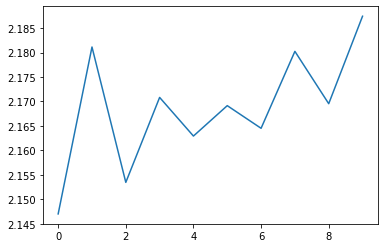

In [27]:
# Training

lr = 1e-3

max_epoch = 10
updates_per_epoch = 100

epoch_record = np.zeros([max_epoch,])

for epoch_id in range(max_epoch):
    
    loss_record = np.zeros([updates_per_epoch,])
    
    t0 = time()
    
    for step in range(updates_per_epoch):

#         # n_samples
#         ind = np.random.choice(n_samples,FLAGS.batch_size)
#         # ind
#         feed_dict = {learning_rate:lr}
#         feed_dict[input_x] = X[ind]
#         feed_dict[input_y] = Y[ind]
#         feed_dict[input_t] = T[ind]
        
        feed_dict = {learning_rate:lr}
        ind = np.random.choice(n0,FLAGS.batch_size)
        feed_dict[input_x_t0] = X0[ind]
        feed_dict[input_y_t0] = Y0[ind]
        ind = np.random.choice(n1,FLAGS.batch_size)
        feed_dict[input_x_t1] = X1[ind]
        feed_dict[input_y_t1] = Y1[ind]
        
        _,loss_ls_val = sess.run([train_ls, loss_ls], feed_dict)
        
        loss_record[step] = loss_ls_val
    
    t1 = time()
    
    print([epoch_id+1,np.mean(loss_record),t1-t0])
    epoch_record[epoch_id] = np.mean(loss_record)
    
_ = plt.plot(epoch_record)

### Evaluation

In [34]:
# t0_np = np.zeros([n_samples,2],dtype=np.int32); t0_np[:,0] = 1
# t1_np = np.zeros([n_samples,2],dtype=np.int32); t1_np[:,1] = 1

# mu0_hat = tf_eval(mu,n_samples,{input_x: X, input_t: t0_np})
# mu1_hat = tf_eval(mu,n_samples,{input_x: X, input_t: t1_np})

mu0_hat = tf_eval(mu0,n_samples,{input_x_t0: X})
mu1_hat = tf_eval(mu1,n_samples,{input_x_t1: X})

tau_hat = mu1_hat - mu0_hat

pehe_ls = eval_pehe(tau_hat, Tau)

print(pehe_ls)

1.255569544974466


In [ ]:
# np.mean(tau_hat)
_ = plt.plot(Tau,tau_hat,'s')

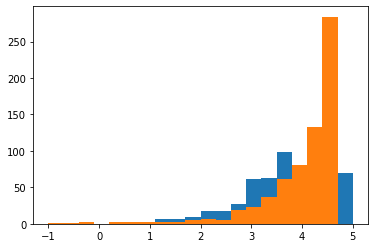

In [38]:
_ = plt.hist(tau_hat,bins=20,range=[-1,5])
_ = plt.hist(Tau,bins=20,range=[-1,5])

In [32]:
mu_hat_t0 = tf_eval(mu0,n0,{input_x_t0: X0})
mu_hat_t1 = tf_eval(mu1,n1,{input_x_t1: X1})

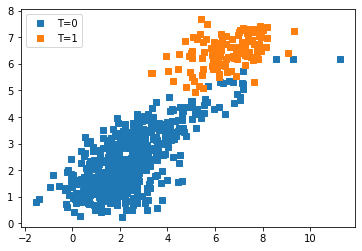

In [33]:
_ = plt.plot(Y0,mu_hat_t0,'s')
_ = plt.plot(Y1,mu_hat_t1,'s')

_ = plt.legend(['T=0','T=1'])